# 🐸 AnuraSet Lab 2 — Embeddings & Linear Models 


At this point you have walked through the steps of the *agile modeling* framework for training machine learning classifiers of audio data. Agile modeling is a specific approach to *(active) transfer learning* -- using an existing machine learning model, which was "pre-trained" on some other (possibly unknown) data, to analyze a new set of data.

Now, we will depart a bit from agile modeling and implement a transfer learning pipeline ourselves from scratch. To do this, we will continue to utilize a pre-trained model to extract *embeddings* -- low dimensional, semantically meaningful representations -- of new data. In the agile modeling notebooks, we built linear classifiers on top of these embeddings datapoint-by-datapoint, labeling example audio clips one at a time until we obtained a decent classifier. In this notebook, we will instead assume we have already exhaustively labeled a large collection of data. We will try to utilize all these labels, along with the raw audio, to train and test a variety of different classifiers.

We will again use *AnuraSet*, a dataset of frog vocalizations, as our test bed. As opposed to the previous notebooks, however, we will *not* be using the 3-second clips and associated metadata. Instead, we will start with raw, 1-minute long audio files, along with species labels of arbitrary duration. We will process these into something that is usable for training. 

This lab will involve the following:

1. **Developing a data loader** that can transform raw audio data into a format that is usable for machine learning: namely, 5-second audio windows with an appropriate sample rate.
2. **Extract audio embeddings** from frog recordings using two pretrained networks: YAMNet and Perch.
3. Practice **OOP** by wrapping each model behind a common `Embedder` interface.
4. **Analyze AnuraSet annotations** to label the species in each 5-second window.
5. **Train linear classifiers** (e.g., logistic-regression) with scikit-learn to classify species based on embeddings.

Gaps marked **📝 Exercise** should be completed by you.  

In [1]:
# from chatgpt, to test tensorflow installation correct
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

a = tf.constant([1.0, 2.0])
b = tf.constant([3.0, 4.0])
print("Sum:", tf.add(a, b))


2025-05-13 16:17:18.129578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747153038.148468   96883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747153038.154731   96883 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 16:17:18.174946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF version: 2.18.0
TF Hub version: 0.16.1
Sum: tf.Tensor([4. 6.], shape=(2,), dtype=float32)


I0000 00:00:1747153041.857606   96883 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5579 MB memory:  -> device: 0, name: GRID A100X-8C, pci bus id: 0000:04:00.0, compute capability: 8.0


In [2]:
# ------------------------------------------------------------
# SETUP
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import librosa
import tensorflow_hub as hub
from pathlib import Path
from IPython.display import Audio, display
from tqdm.auto import tqdm
import glob
import matplotlib.pyplot as plt

2025-05-15 19:05:53.070954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747335953.089211  108862 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747335953.096246  108862 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 19:05:53.122891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# ------------------------------------------------------------
# Directory structure
# ------------------------------------------------------------
DATA_DIR   = Path('/mnt/class_data/anuraset')
RAW_DIR    = DATA_DIR / 'raw_data'         # long recordings (.wav)
LABEL_DIR  = DATA_DIR / 'strong_labels'    # txt annotation files
print('Raw WAV dir  :', RAW_DIR)
print('Label txt dir:', LABEL_DIR)


Raw WAV dir  : /mnt/class_data/anuraset/raw_data
Label txt dir: /mnt/class_data/anuraset/strong_labels


Step 2.


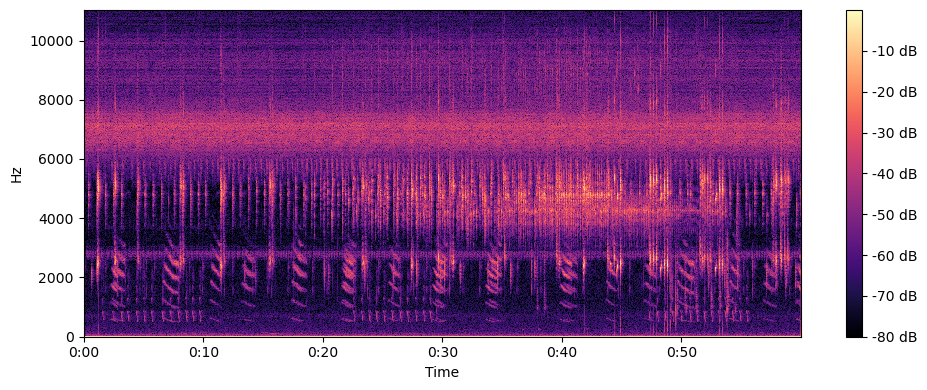

Step 3.
Yeah, found a label file!


In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 1. Data exploration. 
# ------------------------------------------------------------
# We are working with the raw version of Anuraset now. Let's take a minute to see what we've got.
# 
# 1. Use `os.listdir`, `Path.glob` (https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob), and/or navigate via the command line 
#       to investigate the contents of RAW_DIR and LABEL_DIR. What do you see?
# 2. Load an audio file with librosa.load and display it in this notebook with display(Audio(...)) as in Lab 1.
print("Step 2.")
loc_dir = 'INCT17'  # directory path for different recording locations
fl = glob.glob("%s/%s/*.wav" % (RAW_DIR, loc_dir))
# load sample .wav file
wav, sr = librosa.load(fl[0], sr=None)
time_wave = np.arange(len(wav)/sr)  # time array of audio file [s]
# play sample wav file
display(Audio(fl[0]))

# view spectrogram
stft = librosa.stft(wav)
amp_stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(amp_stft_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# 3. Load the corresponding label file with pandas and display its head().
#       a. Things might look weird. Check out the `sep` keyword of pd.read_csv: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
#       b. What do you think the different columns correspond to? Feel free to reference the official documentation of the Anuraset dataset.
#       c. Use header=None, and use the `names` parameter to label the columns appropriately.

# find filename of label
print("Step 3.")
fname_label = fl[0].split("/")[-1].strip(".wav")
fl_label = glob.glob("%s/%s/%s*" % (LABEL_DIR, loc_dir, fname_label))
if len(fl_label) > 0:
    labels = pd.read_csv(fl_label[0], sep="\t", header=None, names=['stime', 'etime', 'species'])
    print("Yeah, found a label file!")
else:  
    print("Label file not found!")

# 4. Find a labeled frog call whose duration is shorter than the total length of the clip.
#       a. Extract and display the corresponding sub-clip from the longer clip you loaded in (2)
#           Hint: Audio files can be indexed by sample in a similar manner to list indexing in Python. 
#                 Use the sample rate (from librosa) and the timestamps (in seconds) from the annotation file to get to the correct indices.

# find instances of PHYALB_L
SPECIES = 'PHYALB_L'
phyalb_df = labels[labels['species'] == SPECIES]  # return new df

def time_sample_audio(wav, sr, time_start, time_end):
    wav_segment = wav[int(time_start*sr):int(time_end*sr)]
    time_segment = np.arange(time_start, time_end)
    return wav_segment, time_segment

# get temporal sample of wav file
wav_seg, time_seg = time_sample_audio(wav, sr, phyalb_df['stime'].iloc[11], phyalb_df['etime'].iloc[11])


#       b. Load and display the corresponding sub-clip using librosa.load. 
#           This is a convenient way to load a short clip without reading the entire WAV file into memory, and may be useful later.
#           Hint: Look at the `offset` and `duration` parameters: https://librosa.org/doc/main/generated/librosa.load.html
# ------------------------------------------------------------

display(Audio(data=wav_seg, rate=sr))

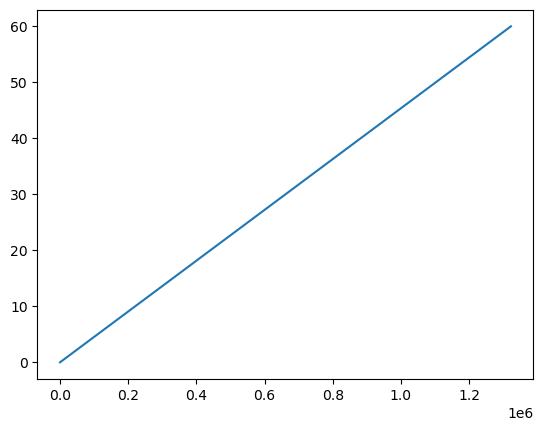

In [8]:
time_array = np.arange(len(wav))/sr
plt.figure()
plt.plot(time_array, '-')
plt.show()

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 2. Write a data loader.
# ------------------------------------------------------------
# Machine learning by definition typically involves reading and processing a lot of data.
# Some things must happen before the data is actually given to the model: we need to read
# it from disk into memory, (optionally) transfer it to GPU memory, transform it into the
# format the model needs (e.g. from raw audio into spectrograms), etc.
#  
# How to do this efficiently is a challenge. For example, if our dataset contains a lot of large
# files, it can take a long time to load them from disk; this causes delays in training
# because the model has to wait for all the data to be loaded into memory before it 
# can take another training step. Well-designed dataloaders minimize this latency.
#
# We are going to build a dataloader that can efficiently transform the 1-minute-long AnuraSet
# audio files into 5-second long audio chunks. We will do this because Perch and YAMNet --
# the pre-trained models we will use to extract embeddings -- expect 5-second long audio clips.
# This is another thing about data loaders to keep in mind: they are often somewhat model-specific!
# If we were instead using a pre-trained audio model that expected spectrograms as input, we 
# would need to generate those ourselves, taking care to match the exact spectrogram generation
# settings that the model was originally trained with. Perch and YAMNet avoid this complication by
# accepting raw audio and performing the spectrogram generation internally through what is called an
# "audio frontend". Still, there are some things we need to match -- namely, audio length and sample rate.
#
# We will take advantage of Python *generator functions* for this task. A Python generator is like a 
# lazy function for creating a list: instead of returning all values in the list at once, a generator
# "yield"s one item at a time and then stops, keeping track of its state, and does no further
# computation until it is asked for the next item. We can use this as follows: for each one-minute audio
# file, instead of processing the whole thing at once and generating 12 5-second audio clips,
# we can quickly "yield" the first clip and wait until the second one is requested, then "yield" that
# one and wait, and so on.
#
# Like most things, this is easiest to understand by actually implenting it. Complete the audio_chunk_dataloader
# (a generator function) below as follows:
#
# 1. Use glob to get a list of all audio files that match the `file_glob``. This glob will look something like
#    path/to/audio/*.wav. If `shuffle`` is true, shuffle the order of this list.
#
# 2. For each file, iterate in `window_size_s`-second chunks and `yield` a tuple containing:
#    (audio, filepath, offset), where `audio` is a `window_size_s`-second audio file at `target_sample_rate`,
#    `filepath` is the path to the full audio file, and `offset` is the start time in seconds of the chunk.
#     Hint: rather than loading the big audio files from disk, use librosa.get_duration with the `path` argument 
#     to figure out the number of chunks in a each audio file, then load each chunk separately (as above) with librosa.load.
#     This will make it easier to parallelize things later, since we won't have to wait for a big audio file
#     to load every few data batches.
#     Hint #2: Some files are not exactly 60s long, they may be something like 59.6s long. Make sure you 
#     handle this when calling librosa.load on the last chunk of the file.
# ------------------------------------------------------------
def audio_chunk_dataloader(file_glob, target_sample_rate, window_size_s, shuffle=False):
    """
    Args:
        file_glob: str, glob pattern for the audio files
        target_sample_rate: int, sample rate to load the audio files
        window_size_s: float, size of the audio chunks in seconds
        shuffle: bool, whether to shuffle the order of the audio files in the glob; use a fixed seed for reproducibility
    Yields:
        audio_window: np.ndarray, audio chunk
        file: str, path to the audio file
        offset: float, start time of the audio chunk in seconds

    Hint:
    for file in glob:
      for audio_window in file:
        yield audio_window, file, offset
    """
    raise NotImplementedError


## Test:
file_glob = str(RAW_DIR / '**/*.wav')
target_sample_rate = 16000
window_size_s = 5.0
dataloader = audio_chunk_dataloader(file_glob, target_sample_rate, window_size_s, shuffle=True)
num_to_test = 15
for i, (audio_chunk, file, offset) in tqdm(enumerate(dataloader)):
    print(f"Loaded {file} at {offset:.2f}s")
    display(Audio(audio_chunk, rate=target_sample_rate))
    if i > num_to_test: break

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 3.1 Chunked inference on a single file with YAMNet.
# ------------------------------------------------------------
# Let's get some embeddings! We will do this for a single file first.
# We will iterate over all chunks in this file using our new dataloader, 
# and ask our pre-trained model to perform inference on each audio chunk.
#
# Let's start with the YAMNet model. Google has provided instructions for
# how to run inference here: https://www.tensorflow.org/hub/tutorials/yamnet#executing_the_model
# These will need to be modified slightly to fit into our approach; 
# in particular you can ignore most of their data setup and focus on the 
# "Executing the Model" section. 
#
# 1. Fill in the method below to extract an embedding from each chunk, and 
#    append this embedding to the embeddings list.
#
# Note that YAMNet internally splits each chunk into 0.48s 'frames' and returns one embedding for each.
# We will follow the following approach:
# "When a model’s window size is shorter than a target example, we frame the audio according to the model’s window size, 
# create an embedding for each frame, and then average the results" https://www.nature.com/articles/s41598-023-49989-z
#
# Hint: this involves taking a mean over all the embeddings of all the frames for each chunk. Make sure
# your tensor shape looks correct after performing this mean: each embedding should have shape (1024,)
# ------------------------------------------------------------

def inference_yamnet():
    CHUNK_LEN_S = 5     # use 5s chunks
    TARGET_SR = 16_000  # YAMNet expects a 16khz sample rate

    # load the model
    yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

    # for testing, lets just look at one file
    # note this is a valid file_glob for creating our dataloader!
    sample_file = '/mnt/class_data/anuraset/raw_data/INCT20955/INCT20955_20191031_030000.wav'

    # iterate through the file in CHUNK_LEN_S chunks and append each embeddding to this list
    embeddings = []
    dataloader = audio_chunk_dataloader(sample_file, TARGET_SR, CHUNK_LEN_S)    # note a single filepath is also a valid glob pattern
    for chunk, _, _ in dataloader:                                              # we don't need the filepath and offset now, so use dummy variable _ to ignore them
        # Fill this in
        raise NotImplementedError
    
    # stack the embeddings into one big array
    embeddings = np.stack(embeddings)
    return embeddings

# Test:
assert inference_yamnet().shape == (12, 1024), "YAMNet embeddings should be of shape (12, 1024) for a 1 minute clip"

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 3.2 Chunked inference on a large file with Perch.
# ------------------------------------------------------------
# Now let's do the same thing for the Perch model. You can reference some example code here:
# https://www.kaggle.com/models/google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier/4?tfhub-redirect=true
# to see how inference with Perch differs from inference with YAMNet.
#
# Notably, Perch expects chunks that are *exactly* 5 seconds long. Some of the files in our
# dataset are annoyingly *not* exactly 60 seconds long; they are something like 59.6 seconds long.
# We provide a convenience method below to pad any numpy array to a given size, which you can
# use to tackle this.
#
# 1. Fill in the inference_perch() method below. The return type should be the same as inference_yamnet(),
# except the embedding size is different; each embedding should be shape (1280,)

def zeropad(A, size):
    """Convenience function to pad a numpy array to a given size. Useful for Perch, which requires 5s chunks."""
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

def inference_perch():
    CHUNK_LEN_S = 5
    TARGET_SR = 32_000  # Perch is 32khz

    perch_model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/4')
    sample_file = '/mnt/class_data/anuraset/raw_data/INCT20955/INCT20955_20191031_030000.wav'

    embeddings = []
    dataloader = audio_chunk_dataloader(sample_file, TARGET_SR, CHUNK_LEN_S)
    for chunk, _, _ in dataloader:
        raise NotImplementedError

    embeddings = np.stack(embeddings)
    return embeddings

# Test:
assert inference_perch().shape == (12, 1280), "Perch embeddings should be of shape (12, 1280) for a 1 minute clip"


In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 4. OOP practice
# ------------------------------------------------------------
# We duplicated a lot of code in the above two methods. Most of the logic for
# running inference is exactly the same regardless of which model you are
# using to extract embeddings. The only difference is the model-specific logic
# for running inference. This sounds like a great fit for an object-oriented design!
#
# We will define an Embedder class to encapsulate this model-specific logic.
# First, we will define a base class (AKA "parent class") called `Embedder`; 
# then we can create "child classes" for both YAMNet and Perch that extend from Embedder.
# Later code can treat them exactly the same.
#
# 1. Fill in the __init__ and __call__ methods of YAMNetEmbedder and PerchEmbedder.
# This involves setting the instance variables self.target_sr and self.model to 
# appropriate values for each; then filling in inference code. See test_perch_embedder()
# below for an example of how these methods will be called.
# Hint: you shouldn't really need to write any new code if you implemented the above
# methods correctly...
# ------------------------------------------------------------

# Don't modify this class! It is purposely left NotImplemented to indicate to subclasses
# what the expected interface should be.
class Embedder:
    def __init__(self):
        # You don't need to modify this!
        # Override these in subclasses:
        self.target_sr = -1
        self.model = None

    def __call__(self, audio_chunk):
        """
        You don't need to modify this! 
        Subclasses are required to override this logic.

        Args:
            audio_chunk: np.ndarray, shape (chunk_size_in_seconds*sample_rate,), the audio chunk to embed
        Returns:
            embedding: np.ndarray, shape (embedding_dim,), the embedding of the audio chunk
        """
        raise NotImplementedError
    
class YAMNetEmbedder(Embedder):
    def __init__(self):
        raise NotImplementedError

    def __call__(self, audio_chunk):
        raise NotImplementedError
    
class PerchEmbedder(Embedder):
    def __init__(self):
        raise NotImplementedError

    def __call__(self, chunk):
        raise NotImplementedError

# Test
def test_perch_embedder():
    embedder = PerchEmbedder()
    sample_file = '/mnt/class_data/anuraset/raw_data/INCT20955/INCT20955_20191031_030000.wav' # example
    dataloader = audio_chunk_dataloader(sample_file, embedder.target_sr, embedder.chunk_size_s)
    
    for chunk, _, _ in dataloader:
        embedding = embedder(chunk)
        print(embedding.shape)
        assert embedding.shape == (1280,)
        break  # Only test the first chunk
    print("PerchEmbedder test passed!")

test_perch_embedder()

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 5. Extract embeddings and file information
# ------------------------------------------------------------
# Let's start generating a dataset of embeddings that we can use to train a species classifier.
# We will start small, and generate embeddings for 100 audio chunks. Then, (in the next exercise)
# we will extract labels for these files; finally (in a couple more exercises) we will use
# these embeddings+labels to train a classifier.
#
# 1. Using your dataloader and Embedder classes, generate Perch embeddings of all audio chunks at SITE.
#    Use shuffle=True in your dataloader to get a diverse set at the front of the list.
#    Put results into two lists:
#    embeddings -> list of np.ndarray, each of shape (embedding_dim,)
#    file_info -> list of tuples, each is (filepath, offset_s)
#        this will allow us to remember where each embedding came from so that we can associate each 
#        embedding with a species label later
# ------------------------------------------------------------

# for now, just embed a subset (of MAX_FILES) at a sample site for proof of concept (to reduce wait time)
SITE = 'INCT17'
MAX_CHUNKS = 100
CHUNK_LEN_S = 5
print("Embedding", MAX_CHUNKS, "audio snippets of length", CHUNK_LEN_S, "seconds at site", SITE)

embeddings = []
file_info = []
embedder = ...
dataloader = ...
# then: for ... in dataloader: ...

# Test
embeddings = np.stack(embeddings)
assert embeddings.shape == (100,1280)

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 6. Extract labels for binary classification 
# ------------------------------------------------------------
# In order to train a model to classify the species in each audio chunk,
# we need species labels for each chunk. For now, we will pick a single
# target species, and train a "binary classifier", i.e., a classifier
# with only two classes. In our case, the classes are "our target species is
# not present" vs. "our target species is present". We will give the former
# the class label of 0, and the latter the class label of 1. (i.e, a 1 means
# our species of interest is present in the clip.)
# 
# Above, you explored what the label files look like: species labels with time
# ranges of when they are present. Now we will process these to determine, for
# each audio chunk returned by our data loader, if the label should be a 0 or 1
# for our target species.
#
# For each audio chunk we have embedded,
# 1. Using the file information, find and load the associated label file using pandas.
#    Hint: you did this at the beginning of this notebook.
# 2. Each label file represents an entire one-minute audio file. Filter the pandas
#    dataframe down to labels that apply to the current 5-second chunk.
#    Hint: remember that the dataloader returns an `offset` that tells you where the
#    current chunk is located in the longer audio file.
# 3. Append either a 0 or 1 to the `ys` list depending on whether your target_species
#    is in this chunk.
# ------------------------------------------------------------
target_species = 'DENMIN_M'

ys = []
for i, (file, offset) in enumerate(file_info):
    # Fill this in
    pass

# Test: make sure we have one label per embedding
assert len(ys) == embeddings.shape[0]

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 6.1 Verify you don't have any bugs!
# ------------------------------------------------------------
# Use the audio visualization code from the first notebook to check a few positive 
# and negative examples of your target species. Does everything look (/sound)
# as expected?
# ------------------------------------------------------------


In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 7. Train a simple logistic regression model 
# ------------------------------------------------------------
# At long last, we are ready to train a model to classify embeddings
# as containing our target_species or not.
#
# We will use scikit-learn to do so: https://scikit-learn.org/stable/
# 
# 1. First, we need to decide which data we will use to "train" the model,
#    and which data we will use to "test" the model, i.e. determine whether
#    the training process is going well. Create a simple random train/test 
#    split using sklearn's train_test_split function, Stratify by class labels 
#    (ys) to ensure that the training and test sets have the same proportion of 
#    positive and negative examples.
#    Food for thought: This method randomly splits our data into train and test. 
#       When is this appropriate or inappropriate to do? Does this give us an 
#       accurate picture of how the model will perform on future data? Why or why not?
#
# 2. Train a logistic regression model. There are lots of tutorials out there for 
#    how to do this with scikit learn; the imports in this cell also give you some hints.
#    The X's will be our embeddings; the Y's will be our labels.
#
# 3. Evaluate your trained model on the test set. Print the ROC-AUC score on the test set.
# ------------------------------------------------------------

# there are hints hidden in these imports...
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 8. Train KNN
# ------------------------------------------------------------
# In logistic regression, "training" inolves drawing a decision boundary
# between the 0 class and the 1 class in the embedding space. 
# "Inference" then involves just determining which side of this boundary
# a new test point lies on. This is a "parametric" model, since the decision
# boundary is defined by slope and intercept parameters.
#
# An alternate, non-parametric approach is a "nearest neighbors" classifier.
# This is basically what it sounds like: when performing inference, look at our
# training set (the points we have labels for). Find the training examples
# that are closest to the new test point in the embedding space, and just go ahead
# and say the new test point is probably the same class as those! This doesn't
# even really require "training", as no parameters are fit. (The number of
# neighbors to consider is a "hyperparameter" that is set by the user rather
# than learned from data).
#
# 1. Create, fit, and evaluate a KNeighborsClassifier on the same X's and Y's as above.
#    Print the ROC-AUC score. 
#    Hint: There are two ways you can predict in scikit-learn: predict() and predict_proba(). 
#    How does the choice of prediction affect your ROC-AUC score? Why? Which one is more
#    appropriate to use?
#
# ------------------------------------------------------------
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 8. Train a model on all the data!
# ------------------------------------------------------------
# TODO:
# Point to embeddings we've extracted for everywhere
# Train/test splits: random vs. sites
# ------------------------------------------------------------

In [ ]:
# Optional extensions
# ------------------------------------------------------------
# 1. Try out different classifiers (e.g. SVM, Random Forest, NN, etc.) and see how they perform.
# 2. Try out different embedding models (e.g. YAMNet, Perch, etc.) and see how they perform.
# 4. Try out different data augmentation techniques (e.g. pitch shifting, time stretching, etc.) and see how they affect the performance of your classifier.
# 5. Try out different hyperparameters (e.g. learning rate, batch size, etc.) and see how they affect the performance of your classifier.